In [87]:
!pip install cleverhans

In [96]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
import matplotlib.pyplot as plt

tf.__version__

'2.17.0'

In [99]:
# Chargement des données

X_train_full = np.load('X.npy')
y_train_full = np.load('y.npy')
X_test = np.load('X_val.npy')
y_test = np.load('y_val.npy')


X_train_full = np.array(X_train_full[:,:-2])
X_test = np.array(X_test[:,:-2])

print("X_train_full shape from MIT-BIH:",X_train_full.shape)
print("X_text shape from MIT-BIH:",X_test.shape)

np.save('X_train_full.npy', X_train_full)
np.save('X_test.npy', X_test)
np.save('y_train_full.npy', y_train_full)
np.save('y_test_arrythmia_classes.npy', y_test)


X_train_full shape from MIT-BIH: (5000, 181)
X_text shape from MIT-BIH: (5000, 181)


In [100]:
class_names = {'A':'Atrial premature contraction (A)', 'V':'Premature venticular contraction (V)',
               'N':'Normal beat (N)', 'L':'Left bundle branch block (L)', 'R':'Right bundle branch beat (R)'}
mapping_to_numbers = {}
y_train_full_number = np.zeros(len(y_train_full), dtype=int)
for i, raw_label in enumerate(y_train_full):
    if raw_label not in mapping_to_numbers:
        mapping_to_numbers[raw_label] = len(mapping_to_numbers)
    y_train_full_number[i] = mapping_to_numbers[raw_label]


# Traitement de y_test avec les mêmes mappings

y_test_number = np.zeros(len(y_test), dtype=int)
for i in range(len(y_test)):
    y_test_number[i] = mapping_to_numbers[y_test[i]]

print("Class names for numbers:", mapping_to_numbers)


Class names for numbers: {'A': 0, 'V': 1, 'N': 2, 'L': 3, 'R': 4}


In [101]:
X_valid, X_train = X_train_full[:2500], X_train_full[2500:]
y_valid_full_number, y_train_full_number = y_train_full_number[:2500], y_train_full_number[2500:]


y_train_categorical = to_categorical(y_train_full_number, num_classes=5)
y_valid_categorical = to_categorical(y_valid_full_number, num_classes=5)

print(f'Taille de X_train: {X_train.shape}')
print(f'Taille de y_train_categorical: {y_train_categorical.shape}')
print(f'Taille de X_valid: {X_valid.shape}')
print(f'Taille de y_valid_categorical: {y_valid_categorical.shape}')

Taille de X_train: (2500, 181)
Taille de y_train_categorical: (2500, 5)
Taille de X_valid: (2500, 181)
Taille de y_valid_categorical: (2500, 5)


In [102]:
model = Sequential()
model.add(Conv1D(32, 3, activation='relu', input_shape=(181, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_69 (Conv1D)                   │ (None, 179, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_69 (MaxPooling1D)      │ (None, 89, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_70 (Conv1D)                   │ (None, 87, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_70 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 41, 32)              │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_71 (MaxPooling1D)      │ (None, 20, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 5)                   │           3,205 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,717 (61.39 KB)

 Trainable params: 15,717 (61.39 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
# Entraînement du modèle
history = model.fit(X_train, y_train_categorical, epochs=30, batch_size=32, validation_split=0.3)


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2878 - loss: 1.5538 - val_accuracy: 0.5760 - val_loss: 1.2060
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5361 - loss: 1.1634 - val_accuracy: 0.7227 - val_loss: 0.8371
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6376 - loss: 0.9221 - val_accuracy: 0.8067 - val_loss: 0.7033
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7388 - loss: 0.8109 - val_accuracy: 0.8013 - val_loss: 0.6301
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7582 - loss: 0.7258 - val_accuracy: 0.8373 - val_loss: 0.5664
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7799 - loss: 0.6718 - val_accuracy: 0.8440 - val_loss: 0.5259
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8025 - loss: 0.5947 - val_accuracy: 0.8640 - val_loss: 0.4787
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8305 - loss: 0.5448 - val_accuracy: 0.8507 - v

In [104]:
# Évaluation des performances sur l'ensemble de validation
clean_loss, clean_accuracy = model.evaluate(X_valid, y_valid_categorical, verbose=0)
print('Valeur de la loss:' ,clean_loss)
print(f'Valeur Clean accuracy: {clean_accuracy*100:.2f}%')

Valeur de la loss: 0.26787444949150085
Valeur Clean accuracy: 90.92%


Valeur Clean accuracy: 90.92%
Adversarial accuracy (FGSM): 53.0800
Adversarial accuracy (PGD): 36.8000
Max perturbation for FGSM: 0.0500
Max perturbation for PGD: 0.0500


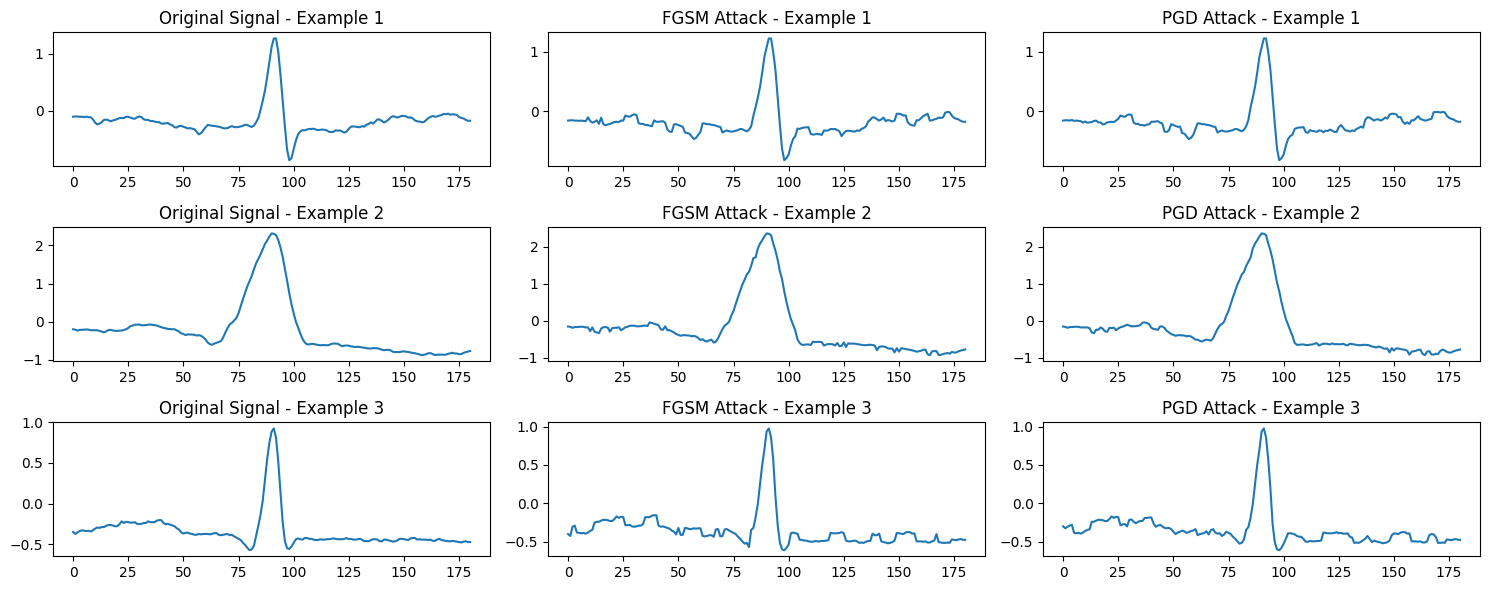

In [105]:

#Création des modèles d'attaques FGSM ainsi que PGD

#On affiche à nouveau l'accuracy

print(f'Valeur Clean accuracy: {clean_accuracy*100:.2f}%')
# Paramètres de l'attaque PGD

adv_perturbation_budget = 0.05  # Perturbation maximum
pgd_step_budget = 0.01  # Pas de l'attaque
pgd_iterations = 40  # Nombre d'itérations


# attaque FGSM

X_valid_adv_fgsm = fast_gradient_method(model, X_valid, adv_perturbation_budget, np.inf)  # Appliquer l'attaque FGSM

# Evaluation sur les données adversariales (FGSM)

adv_loss_fgsm, adv_accuracy_fgsm = model.evaluate(X_valid_adv_fgsm, y_valid_categorical, verbose=0)
print(f'Adversarial accuracy (FGSM): {adv_accuracy_fgsm*100:.4f}')

# attaque PGD

X_valid_adv_pgd = projected_gradient_descent(model, X_valid, adv_perturbation_budget, pgd_step_budget, pgd_iterations, np.inf)  # Appliquer l'attaque PGD

# Evaluation sur les données adversariales (PGD)
adv_loss_pgd, adv_accuracy_pgd = model.evaluate(X_valid_adv_pgd, y_valid_categorical, verbose=0)
print(f'Adversarial accuracy (PGD): {adv_accuracy_pgd*100:.4f}')

max_perturbation_fgsm = np.max(np.abs(X_valid_adv_fgsm - X_valid))
max_perturbation_pgd = np.max(np.abs(X_valid_adv_pgd - X_valid))
print(f"Max perturbation for FGSM: {max_perturbation_fgsm:.4f}")
print(f"Max perturbation for PGD: {max_perturbation_pgd:.4f}")

plt.figure(figsize=(15, 6))

# Exemple 1
plt.subplot(3, 3, 1)
plt.plot(X_valid[0], label="Original")
plt.title("Original Signal - Example 1")

plt.subplot(3, 3, 2)
plt.plot(X_valid_adv_fgsm[0], label="FGSM Perturbed")
plt.title("FGSM Attack - Example 1")

plt.subplot(3, 3, 3)
plt.plot(X_valid_adv_pgd[0], label="PGD Perturbed")
plt.title("PGD Attack - Example 1")

# Exemple 2
plt.subplot(3, 3, 4)
plt.plot(X_valid[1], label="Original")
plt.title("Original Signal - Example 2")

plt.subplot(3, 3, 5)
plt.plot(X_valid_adv_fgsm[1], label="FGSM Perturbed")
plt.title("FGSM Attack - Example 2")

plt.subplot(3, 3, 6)
plt.plot(X_valid_adv_pgd[1], label="PGD Perturbed")
plt.title("PGD Attack - Example 2")

# Exemple 3
plt.subplot(3, 3, 7)
plt.plot(X_valid[2], label="Original")
plt.title("Original Signal - Example 3")

plt.subplot(3, 3, 8)
plt.plot(X_valid_adv_fgsm[2], label="FGSM Perturbed")
plt.title("FGSM Attack - Example 3")

plt.subplot(3, 3, 9)
plt.plot(X_valid_adv_pgd[2], label="PGD Perturbed")
plt.title("PGD Attack - Example 3")

plt.tight_layout()
plt.show()